In [1]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time
from IPython import display

# import functions from other python files
from fun1d import *
from optim import *

In [56]:
class parameter:
    def __init__(self, niter, nepoch, nbatch, optim, eta, beta, gamma, epsilon):
        self.niter = niter
        self.nepoch = nepoch
        self.nbatch = nbatch
        self.optim = optim # optimization option
        self.eta = eta
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon

In [63]:
def syn_SGD(x, psi_hat, psi, param, *args):
    # collect parameters
    nx = x.shape
    nw = psi_hat.shape[1]  # number of wavelets 
    max_epoch = param.nepoch
    optim = param.optim
    
    # scattering coefficients of original signal
    sx = np.sum(np.abs(wave_trans_in_freq_1d(x, psi_hat)),axis = 0)

    # initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random(nx[0]) 
    else:
        y0 = args[0]
        
    res = np.zeros((nx[0], max_epoch))
    for i in range(max_epoch):
        print('epoch: ', i)
        if optim == 'sgd':
            res[:, i] = sgd(y0, sx, psi_hat, psi, param)
        elif optim == 'sgd_with_mom':
            res[:, i] = sgd_with_mom(y0, sx, psi_hat, psi, param)
        elif optim == 'nag':
            res[:, i] = nag(y0, sx, psi_hat, psi, param)
        elif optim == 'rmsprop':
            res[:, i] = rmsprop(y0, sx, psi_hat, psi, param)
        elif optim == 'adam':
            res[:, i] = adam(y0, sx, psi_hat, psi, param)
        else:
            print('No such optimization algorithm.')
            break
        y0 = res[:, i]
        sy = np.sum(np.abs(wave_trans_in_freq_1d(y0, psi_hat)),axis = 0)
        print('current error: ', np.sum((sx - sy)**2))
    return res

def jacfun(y0, sx, psi_hat, psi):
    # jacobian function for difference
    epsilon = 1e-6
    n = y0.shape[0]
    nw = psi_hat.shape[1]
    
    temp1 = wave_trans_in_freq_1d(y0, psi_hat)
    temp3 = np.zeros(n)
    
    psi_shift = np.zeros((n,n), dtype = complex)
    
    sy = np.sum(np.abs(temp1), axis = 0)
    
    for i in range(nw):
        temp2 = temp1[:,i]
        for p in range(n):
            psi_shift[:, p] = np.roll(psi[:, i], p, axis = 0)
        temp = np.matmul(np.divide(np.real(temp2), abs(temp2) + epsilon), np.real(psi_shift)) + \
               np.matmul(np.divide(np.imag(temp2), abs(temp2) + epsilon), np.imag(psi_shift))
        temp3 = temp3 + 2 * (sy[i] - sx[i]) * temp
    return temp3

In [79]:
# set parameters
n = 2**10
pi = math.pi
l = 0.05

niter = 100
nbatch = 10
nepoch = 5
eta = 1e-3
beta = 0.99
gamma = 0.9
epsilon = 1e-8
optim = 'adam'

param = parameter(niter = niter, 
                  nepoch = nepoch, 
                  nbatch = nbatch, 
                  optim = optim, 
                  eta = eta, 
                  beta = beta, 
                  gamma = gamma, 
                  epsilon = epsilon)
# sample signal
t = np.linspace(0, n + 1, n + 1)
y = sample_poisson(t, l)[0]
dy = np.diff(y)

# set up scales s and frequencies xi
s = np.unique(np.floor(2 ** np.linspace(1/2, np.log2(n/2), int(2*np.log2(n/2)))))
xi = 2 * pi * np.random.choice(n,1) / n

# build wavelets
g, g_hat = window_filter_family_1d(n, s, xi)
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))


In [80]:
# use SGD to synthesis
res = syn_SGD(dy, g_hat, g, param)

epoch:  0
current error:  15371918.96971971
epoch:  1
current error:  14496167.864322323
epoch:  2
current error:  17332810.307287253
epoch:  3
current error:  13645254.513165012
epoch:  4
current error:  12233252.085379167


In [4]:
# compute f
# nsample = 5000
# f = prod_f(g_hat, t, nsample, l)
# f1 = np.mean(np.abs(wave_trans_in_freq_1d(dy, g_hat)), axis = 0)

In [5]:
# plt.figure(figsize = (10,10))
# plt.subplot(2,1,1)
# plt.plot(s, np.divide(f,s)) # ||w||_1 = 1 for standard gaussian
# plt.ylabel('f_xi(s)/s||w||_1')
# plt.xlabel('s')
# plt.subplot(2,1,2)
# plt.plot(s, np.divide(f1,s)) # ||w||_1 = 1 for standard gaussian
# plt.ylabel('f_xi(s)/s||w||_1')
# plt.xlabel('s')

In [84]:
# load results synthesized by previous optimization method(add one wavelet each optimization)
res1 = np.load('res_poisson2.npy')
g_hat1 = np.load('g_hat.npy')
res1.shape

(1024, 53)

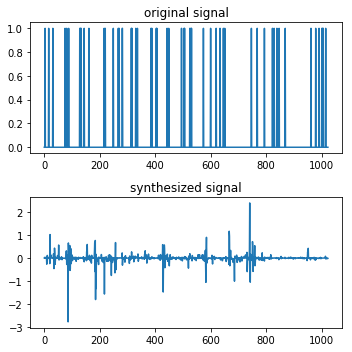

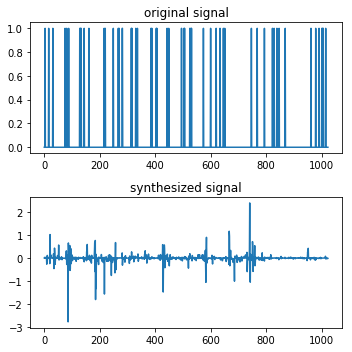

In [87]:
fig = plt.figure()
plt.figure(figsize = (5,5))
plt.subplot(2,1,1)
plt.plot(res1[:, 0]) # target signal
plt.title('original signal')
ax2 = plt.subplot(2,1,2)
for i in range(res1.shape[1] - 1):
    ax2.clear()
    ax2.plot(res1[:, i+1]) # synthesized signal from each iteration
    ax2.set_title('synthesized signal')
    print(i)
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)

In [91]:
y0 = res1[:,-1]
x = res1[:,0]
sy = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,-1], g_hat1)), axis = 0)
sx = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,0], g_hat1)), axis = 0)
print('scattering difference with wavelets in optimization process:', np.sum((sx - sy)**2))

scattering difference with wavelets in optimization process: 2.357100850320207e-16


In [94]:
y0 = res1[:,-1]
x = res1[:,0]
sy = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,-1], g_hat)), axis = 0)
sx = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,0], g_hat)), axis = 0)
print('scattering difference with wavelets defined by another xi:', np.sum((sx - sy)**2))

scattering difference with wavelets defined by another xi: 8937685.237032149
